In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import scipy 
import unittest

In [2]:
df_battery = pd.read_csv('../data/Battery_Dataset.csv')

## K-Nearest Neighbor Regression

In [3]:
import csv
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold 
import math

import sklearn
import statistics as stcs
import scipy.stats as stats

import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler,scale,MinMaxScaler
from scipy.stats import uniform,expon
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [4]:
#One hot encoding (alphebetical order)


ohe = OneHotEncoder()
ACE = df_battery.loc[:,['anode','cathode','electrolyte']]
ACE = ohe.fit_transform(ACE)
ACE = pd.DataFrame(ACE.toarray())

#new = ohe.fit(X_set)

ACE_col_name = ['A1','C1','C2','C3','E1','E2','E3']
for i in range(len(ACE.columns)):
    ACE = ACE.rename({ACE.columns[i]: ACE_col_name[i]}, axis=1) 
    
df_enbattery = pd.concat([ACE, df_battery],axis=1)

In [5]:
df_enbattery

,A1,C1,C2,C3,E1,E2,E3,cell_id,study,Cycles,...,Min_Current (A),Max_Current (A),Min_Voltage (V),Max_Voltage (V),Charge_Capacity (Ah),Discharge_Capacity (Ah),Charge_Energy (Wh),Discharge_Energy (Wh),Coulombic_Efficiency (%),Energy_Efficiency (%)
0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,SNL_18650_LFP_15C_0-100_0.5-1C_a,snl,"4,551.00",...,-1.1,0.55,1.998,3.6,1.036,1.033,3.495,3.213,99.710425,91.931330
1,1.0,1.0,0.0,0.0,1.0,0.0,0.0,SNL_18650_LFP_15C_0-100_0.5-1C_a,snl,"4,551.00",...,-1.1,0.55,1.996,3.6,1.035,1.032,3.492,3.212,99.710145,91.981672
2,1.0,1.0,0.0,0.0,1.0,0.0,0.0,SNL_18650_LFP_15C_0-100_0.5-1C_a,snl,"4,551.00",...,-1.1,0.55,1.998,3.6,1.034,1.031,3.488,3.210,99.709865,92.029817
3,1.0,1.0,0.0,0.0,1.0,0.0,0.0,SNL_18650_LFP_15C_0-100_0.5-1C_a,snl,"4,551.00",...,-1.1,0.55,1.994,3.6,1.033,1.030,3.490,3.193,99.709584,91.489971
4,1.0,1.0,0.0,0.0,1.0,0.0,0.0,SNL_18650_LFP_15C_0-100_0.5-1C_a,snl,"4,551.00",...,-1.1,0.55,1.998,3.6,1.031,1.028,3.495,3.169,99.709020,90.672389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,1.0,0.0,0.0,1.0,0.0,1.0,0.0,SNL_18650_NMC_35C_0-100_0.5-2C_a,snl,786,...,-6.0,1.50,1.996,4.2,2.529,2.527,9.814,8.388,99.920917,85.469737
316,1.0,0.0,0.0,1.0,0.0,1.0,0.0,SNL_18650_NMC_35C_0-100_0.5-2C_a,snl,786,...,-6.0,1.50,1.994,4.2,2.518,2.506,9.769,8.332,99.523431,85.290204
317,1.0,0.0,0.0,1.0,0.0,1.0,0.0,SNL_18650_NMC_35C_0-100_0.5-2C_a,snl,786,...,-6.0,1.50,1.995,4.2,2.484,2.482,9.650,8.197,99.919485,84.943005
318,1.0,0.0,0.0,1.0,0.0,1.0,0.0,SNL_18650_NMC_35C_0-100_0.5-2C_a,snl,786,...,-6.0,1.50,1.995,4.2,2.477,2.478,9.617,8.208,100.040371,85.348861


In [6]:
data = df_enbattery

np.random.seed(66)
def data_split (df_enbattery, test_ratio):

    total_row = df_enbattery.shape[0]
    test_row = round(total_row *test_ratio)
    train_row = total_row -test_row
    
    indices =np.random.permutation(total_row)
    train_indx, test_idx =indices[:train_row], indices[train_row:]
    train,test = df_enbattery.iloc[train_indx,:], df_enbattery.iloc[test_idx,:]
    X_test = test[['A1','C1','C2','C3','E1','E2','E3','Cycle','temperature','discharge_crate']]
#    y_test = test[['Charge_Capacity (Ah)']]
    y_test = test[['Discharge_Capacity (Ah)']]
#    y_test = test[['Charge_Energy (Wh)']]
#    y_test = test[['Discharge_Energy (Wh)']]
#    y_test = test[['Coulombic_Efficiency (%)']]
#    y_test = test[['Energy_Efficiency (%)']]

    X_train = train[['A1','C1','C2','C3','E1','E2','E3','Cycle','temperature','discharge_crate']]
#    y_train = train[['Charge_Capacity (Ah)']]
    y_train = train[['Discharge_Capacity (Ah)']]
#    y_train = train[['Charge_Energy (Wh)']]
#    y_train = train[['Discharge_Energy (Wh)']]
#    y_train = train[['Coulombic_Efficiency (%)']]
#    y_train = train[['Energy_Efficiency (%)']]
    return train,test,X_train,y_train,X_test,y_test
    
train,test,X_train,y_train,X_test,y_test = data_split(data,0.2)


In [7]:
X_train

,A1,C1,C2,C3,E1,E2,E3,Cycle,temperature,discharge_crate
0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,50,15,1.0
129,1.0,0.0,1.0,0.0,0.0,0.0,1.0,500,15,1.0
201,1.0,0.0,1.0,0.0,0.0,0.0,1.0,100,35,2.0
218,1.0,0.0,0.0,1.0,0.0,1.0,0.0,450,15,1.0
64,1.0,1.0,0.0,0.0,1.0,0.0,0.0,250,25,0.5
...,...,...,...,...,...,...,...,...,...,...
1,1.0,1.0,0.0,0.0,1.0,0.0,0.0,100,15,1.0
16,1.0,1.0,0.0,0.0,1.0,0.0,0.0,350,15,2.0
140,1.0,0.0,1.0,0.0,0.0,0.0,1.0,50,25,0.5
158,1.0,0.0,1.0,0.0,0.0,0.0,1.0,450,25,1.0


In [8]:

kf = KFold(n_splits=10,random_state =66,shuffle= True)
#print(X_test,y_test,X_train,y_train)

In [9]:
print(kf)

KFold(n_splits=10, random_state=66, shuffle=True)


In [10]:
#Data scaling, algorithms that use distance measures are affected by the scale of numerical input variables
#Standardization assumes that your observations fit a Guassian distribution with well-behaved mean and standard deviation
scaler = StandardScaler(with_mean=True,with_std=True)

print(scaler.fit(X_test))
print(scaler.mean_)
X_test = pd.DataFrame(scaler.transform(X_test))

print(scaler.fit(X_train))
print(scaler.mean_)
X_train = pd.DataFrame(scaler.transform(X_train))

StandardScaler()
[  1.         0.296875   0.34375    0.359375   0.296875   0.359375
   0.34375  292.1875    25.3125     1.4375  ]
StandardScaler()
[1.00000000e+00 3.94531250e-01 2.65625000e-01 3.39843750e-01
 3.94531250e-01 3.39843750e-01 2.65625000e-01 2.70703125e+02
 2.53125000e+01 1.45703125e+00]


In [11]:
X_train

,0,1,2,3,4,5,6,7,8,9
0,0.0,1.238811,-0.601417,-0.717491,1.238811,-0.717491,-0.601417,-1.539658,-1.802983,-0.500425
1,0.0,-0.807225,1.662740,-0.717491,-0.807225,-0.717491,1.662740,1.599609,-1.802983,-0.500425
2,0.0,-0.807225,1.662740,-0.717491,-0.807225,-0.717491,1.662740,-1.190851,1.693711,0.594522
3,0.0,-0.807225,-0.601417,1.393746,-0.807225,1.393746,-0.601417,1.250802,-1.802983,-0.500425
4,0.0,1.238811,-0.601417,-0.717491,1.238811,-0.717491,-0.601417,-0.144428,-0.054636,-1.047899
...,...,...,...,...,...,...,...,...,...,...
251,0.0,1.238811,-0.601417,-0.717491,1.238811,-0.717491,-0.601417,-1.190851,-1.802983,-0.500425
252,0.0,1.238811,-0.601417,-0.717491,1.238811,-0.717491,-0.601417,0.553187,-1.802983,0.594522
253,0.0,-0.807225,1.662740,-0.717491,-0.807225,-0.717491,1.662740,-1.539658,-0.054636,-1.047899
254,0.0,-0.807225,1.662740,-0.717491,-0.807225,-0.717491,1.662740,1.250802,-0.054636,-0.500425


In [12]:
# #Grid optimization of hyperparameters
# param_grid = {'n_neighbors':range(1,201),
#               'weights':['uniform', 'distance'],
#               'algorithm':['auto', 'ball_tree', 'kd_tree'],
#              }

# # Create the grid search object
# # Give it the model we want to use, the hyperparameters to search over
# grid_search = GridSearchCV(
#     KNeighborsRegressor(),
#     param_grid,
#     cv=5
# )

# # execute the grid search
# grid_search.fit(X_train, y_train)

# print('Best hyperparameters: ', grid_search.best_params_)

In [13]:
# list(grid_search.best_params_.values())[0]

In [14]:
#Train-error
np.random.seed(66)

KNN_model_train =KNeighborsRegressor(n_neighbors=12, algorithm = 'auto', weights = 'uniform')

train_results =[]
train_results_name =['Experimental','Predicted ','RMSE']


for train_index, test_index in kf.split(X_train):
    #print("Train:", train_index, "Validation:", test_index)
    X_training, X_validate = X_train.iloc[train_index], X_train.iloc[test_index]
    y_training, y_validate = y_train.iloc[train_index], y_train.iloc[test_index]
    np.random.seed(66)
    KNN_model_train.fit(X_training,y_training)
    y_train_predicted = KNN_model_train.predict(X_validate)
    number_validate =X_validate.shape[0]
    mse = mean_squared_error(y_train_predicted, y_validate)
    RMSE = np.sqrt(mse)
    train_results.append([y_validate,y_train_predicted,RMSE])

In [15]:
train_index

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  21,  22,  23,  24,  25,  26,
        28,  29,  30,  31,  33,  34,  35,  36,  37,  38,  40,  41,  42,
        43,  44,  45,  46,  47,  48,  49,  50,  52,  53,  54,  55,  56,
        57,  58,  59,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  76,  77,  78,  80,  81,  82,  83,  84,  85,  86,
        87,  88,  89,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
       101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
       114, 115, 116, 117, 118, 120, 121, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 142,
       143, 145, 146, 147, 148, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
       172, 173, 174, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185,
       186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 19

In [16]:
Train_results =pd.DataFrame (train_results,columns=train_results_name)
np.average(Train_results['RMSE'])

0.5426747155364124

In [17]:
#Test-set Validation
KNN_model =KNeighborsRegressor(n_neighbors=7, algorithm = 'auto', weights = 'uniform')
np.random.seed(66)
KNN_model.fit(X_train,y_train)
y_predict=KNN_model.predict(X_test)
#print(y_predict)

mse = mean_squared_error(y_predict, y_test)
RMSE = np.sqrt(mse)
RMSE

0.5440067456251938

In [18]:
r2_score(y_predict, y_test)

0.4701267182182156

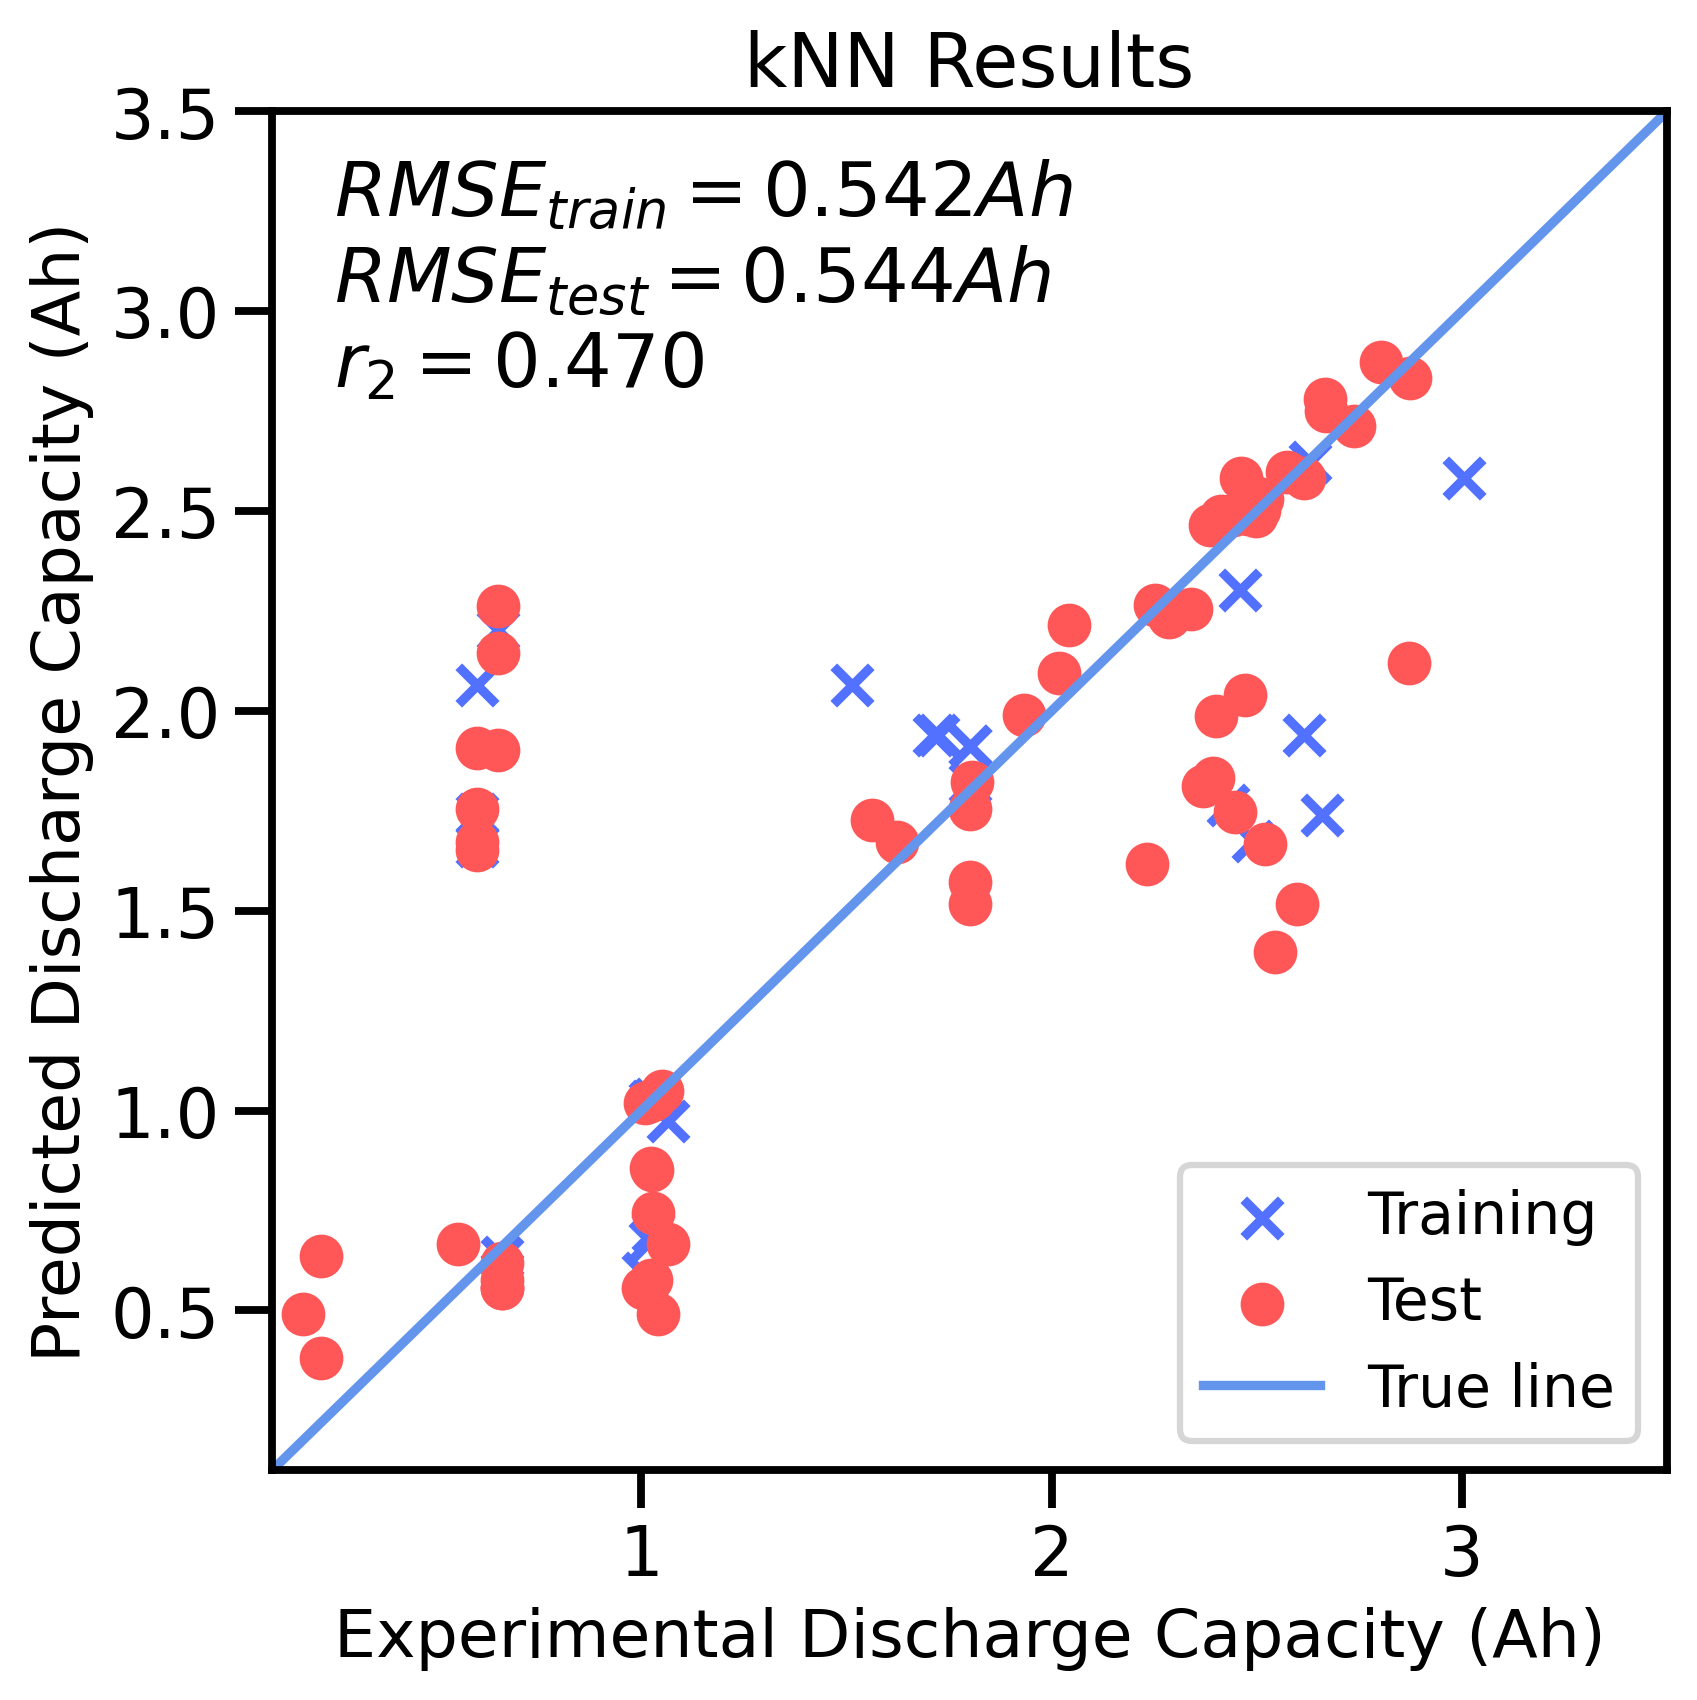

In [28]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
sns.set_context('talk')
figure(figsize=(6, 6), dpi=300)

plt.axis([0.1,3.5,0.1,3.5])
plt.scatter(x = y_validate, y = y_train_predicted, marker = 'x', c='#5271FF',label='Training')
plt.scatter(x = y_test, y = y_predict, c='#FF5757',label='Test')
plt.plot([0,5],[0,5],label ='True line',c='cornflowerblue')
plt.legend(loc='lower right', fontsize = 14)
plt.title(label='kNN Results')

plt.xlabel(r'Experimental Discharge Capacity (Ah)', fontsize = 16)
plt.ylabel(r'Predicted Discharge Capacity (Ah)', fontsize = 16)
plt.text(0.25, 2.6, r'$RMSE_{train}=0.542Ah$'+'\n'+r'$RMSE_{test}=0.544Ah$' +'\n'+ r'$r_{2}=0.470$' +"\n")
#plt.savefig('Guassian_Process-Predicted-vs-test.png',dpi=600)
plt.show()


In [20]:
# ac = df_battery['anode'].unique()
# cc = df_battery['cathode'].unique()
# ec = df_battery['electrolyte'].unique()
# cycle = df_battery['Cycle'].unique()
# tc = df_battery['temperature'].unique()
# cr = df_battery['discharge_crate'].unique()

# X_temp = []
# for a in range(len(ac)):
#     for b in range(len(cc)):
#         for c in range(len(ec)):
#             for d in range(len(cycle)):
#                 for e in range(len(tc)):
#                     for f in range(len(cr)):
#                         X_temp.append([ac[a],cc[b],ec[c],cycle[d],tc[e],cr[f]])
                        
# column_names = ['anode','cathode','electrolyte','Cycle','temperature','discharge_crate']
# X_set = pd.DataFrame(X_temp, columns = column_names)

In [21]:
# X_set

In [22]:
# filehandler = open("ohe.obj","wb")
# pickle.dump(ohe,filehandler)
# filehandler.close()

# file = open("ohe.obj",'rb')
# ohe_loaded = pickle.load(file)
# file.close()


# ace = X_set.loc[:,['anode','cathode','electrolyte']]
# ace = ohe_loaded.transform(ace)
# ace = pd.DataFrame(ace.toarray())

# X_num = X_set.loc[:,['Cycle','temperature','discharge_crate']]

# df_ace_col_name = ['A1','C1','C2','C3','E1','E2','E3']
# for i in range(len(ace.columns)):
#     ace = ace.rename({ace.columns[i]: df_ace_col_name[i]}, axis=1) 
# X_set = pd.concat([ace, X_num],axis=1)

In [23]:
# scaler = StandardScaler()

# print(scaler.fit(X_set))
# print(scaler.mean_)
# X_set = pd.DataFrame(scaler.transform(X_set))

In [24]:
# X_set

In [25]:
# KNN_model = KNeighborsRegressor(n_neighbors=11, algorithm = 'auto', weights = 'uniform')
# np.random.seed(66)
# KNN_model.fit(X_train,y_train)
# y_predict = KNN_model.predict(X_set)
# y_predict = pd.DataFrame(y_predict)
# y_predict

In [26]:
# y_test